In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud
import string
from random import choice

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, train_test_split

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
stopwords_.update(['amp','https'])

In [2]:
def cluster_label(data, col): -> object, object
    '''
    Divides text into topics using pca, Doc2Vec, and kmeans clustering.
    Then creates graphs of each category.
        Args:
            Dataframe data: dataframe to model into topics
            string col: column that contains text to vectorize
        Returns:
            original dataframe,
            matplotlib subplots of graphs
    '''
    
    tweets = data[col]
    tagged_X = [TaggedDocument(t,[i]) for i, t in enumerate(tweets)]

    d2v_model = Doc2Vec(tagged_X, vector_size = 140, epochs = 30,
                    min_count = 500, workers=10, dm = 1, alpha=0.025)

    d2v_model.train(tagged_X, total_examples=d2v_model.corpus_count, 
                    epochs=30, start_alpha=0.002, end_alpha=-0.016)
    kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100)
    vectors_docs = d2v_model.docvecs.vectors_docs
    X = kmeans_model.fit(vectors_docs)
    labels=kmeans_model.labels_.tolist()
    l = kmeans_model.fit_predict(vectors_docs)
    pca = PCA(n_components=2).fit(vectors_docs)
    datapoint = pca.transform(vectors_docs)
    fig, ax = plt.subplots()
    labelc = ['#fc5603', '#03fcf8', '#3103fc', '#0b170d']
    colors = [labelc[i] for i in labels]
    ax.scatter(datapoint[:, 0], datapoint[:, 1], c=colors, s =1)
    centroids = kmeans_model.cluster_centers_

    centroidpoint = pca.transform(centroids)
    ax.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=100, c='#ffff00')
    plt.show()
    
    data['cluster_label'] = labels
    return data,ax

In [3]:
def series_to_TFIDF(corpus): -> object
     '''
     Stemmatizes corpus, then returns its tfidf matrix.
        Args:
            Series corpus: a series of strings
        Returns:
            Object Tfidf matrix of corpus
    '''
    # stem words
    snowb = SnowballStemmer('english')
    corpus = ['\n'.join([snowb.stem(word) for word in word_tokenize(tweet)])
                    for tweet in corpus.values]
    # vectorize w/ ngrams
    vec = TfidfVectorizer(ngram_range = (1,3), tokenizer = word_tokenize, 
                          stop_words = set(wordcloud.STOPWORDS))
    return vec.fit_transform(corpus)

In [4]:
def test_results(preds, y): -> float, float, float, object
     '''
     Tests predictions to actuals and baseline.
        Args:
            Series preds: predicted labels
            Series y: actual labels
        Returns:
            float: test accuracy score
            float: baseline accuracy score
            float: test f1 score
            np.array: test confusion matrix
    '''
        
    # make a baseline that's just uniform random guesses.
    random_preds = [choice([0,1]) for _ in range(len(y))]
    meanbase = len(preds[preds == random_preds])/len(preds)
    # baselines that always guess 1 xor 0
    bases = [(i, len(preds[preds == i])/len(preds)) for i in [0,1]]
    bases = bases + [('random',meanbase)]
    
    #model test accuracy
    acc = ('acc', len(preds[preds == y])/len(preds))
    
    # calculate f1 score
    f1 = ('f1', f1_score(preds, y))
    
    conf_mat = confusion_matrix(y, preds)
    
    return acc, bases, f1, conf_mat


In [5]:
def top_words(data, text_col, stopwords):-> list
    '''
    Returns the top 20 words in a category by tfidf score
        Args:
            Dataframe data: dataframe of category
            string text_col: name of colums that includes text
            list stopwords: list of stopwords
        Returns:
            list - list of 20 most occurring words in category
    '''
    #lemmatize words
    lem = WordNetLemmatizer()
    corpus = data[text_col].apply(lem.lemmatize)
    vec = TfidfVectorizer(tokenizer = word_tokenize, stop_words=stopwords)
    vec.fit(corpus)
    words = pd.Series(vec.idf_, index = vec.get_feature_names())
    top_words = words.sort_values()[:20]
    return top_words

In [6]:
def graph_cluster_words(df, text, stopwords, filename): -> None
    '''
    Graphs top words of a topic by modified tfidf score.
    Saves graph as png.
        Args:
            Dataframe df: dataframe of topic
            string text: name of text column
            list stopwords: list of stopwords
            string filename: name to save file as
        returns:
            None
    '''
    fontA = {'family' : 'normal',
        'size'   : 16}
    fontB = {'family' : 'normal',
            'rotation': 30,
            'size'   : 14}
    
    colors = ['purple','green', 'orange']
    for i, c in enumerate(colors):
        
        fig, ax = plt.subplots(figsize=(20,10))
        plt.xlabel('Word', **fontA)
        plt.ylabel('Topic Importance',**fontA)
        plt.title('Sub-Topic '+str(i+1), **fontA)
        tw = top_words(df[df['cluster_label'] == i], text, stopwords)
        tw = 11 - tw
        x_pos = [i for i, _ in enumerate(tw)]
        ax.bar(x_pos, tw.values, color = c)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(tw.index, **fontB)
        fig.savefig(filename+str(i)+'.png')

In [7]:
#load & clean primary tweets for use

# 174 days
days_raw = [31,30,31,30,31,21] # total days of months between 3/1/2020 - 8/22/2020
labels = ['pos', 'neg']
dates = []

# Stored every data/sentiment on a different csv 
# so I could scrape using cheap machines without straining their memory.
primary_tweets = pd.DataFrame()
for label in labels:
    for month_num, month_days in enumerate(days_raw):
        month = []
        for i in range(month_days):
            filepath = 'tweets_prim/'+label+'2020-{:02d}'.format(month_num+3)+'-{:02d}'.format(i+1)+'.csv'
            if label == 'pos':
                dates.append('2020-{:02d}'.format(month_num+3)+'-{:02d}'.format(i+1))
            try:
                df = pd.read_csv(filepath)
                primary_tweets = primary_tweets.append(df)
            except:
                print(filepath, 'not found')

# Get a date column in addition to datetime                
primary_tweets['date'] = primary_tweets['datetime_tweet'].apply(lambda x: x[:x.find(' ')])
# fully clean clean_text
primary_tweets = primary_tweets.replace({'label': {'pos': 1, 'neg': 0}})
primary_tweets['clean_text'] = primary_tweets['clean_text'].apply(lambda x: str(x).lower().replace('wwg1wga','wwgwga'))
primary_tweets['clean_text'] = primary_tweets['clean_text'].apply(lambda x:''.join([str(i) for i in x 
                                                  if i.isalpha() or i.isspace()]))
#split by label

In [8]:
primary_pos = primary_tweets[primary_tweets['label'] == 1]
primary_neg = primary_tweets[primary_tweets['label'] == 0]
primary_pos,_ = cluster_label(primary_pos, 'clean_text')
primary_neg,_ = cluster_label(primary_neg, 'clean_text')

In [13]:
# Generate word clouds via secndary tweets
# uses pure word count, not tfidf

c_stopwords = set(wordcloud.STOPWORDS)
c_stopwords.update(["will",'1','2','3','4','s','t', 've', 'll','re', "now", "https", "amp", "mask",'people',
                    'wear','one','dont','masks','wearing', '’', 'covid',"”","“", 'im', 'go', 'see',
                    'covid19','coronavirus','don','igshid','want','make','face','say','need','us'])

In [17]:
X = series_to_TFIDF(primary_tweets['clean_text'])
y = primary_tweets['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [22]:
# Train & predict w/ Naive Bayes

model = MultinomialNB()
model.fit(X_train, y_train)
preds = model.predict(X_test)
test_results(preds, y_test)

(('acc', 0.7367893814174806),
 [(0, 0.02504382669671926),
  (1, 0.9749561733032808),
  ('random', 0.48785374405209114)],
 ('f1', 0.8439495174461767),
 array([[ 100, 1051],
        [   0, 2842]]))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


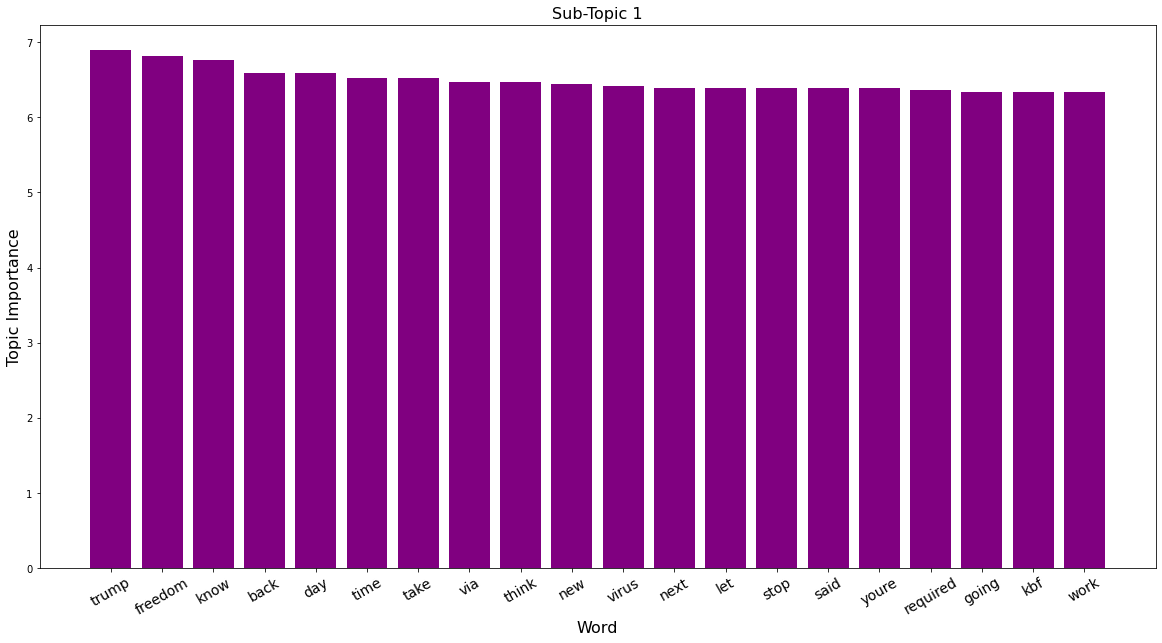

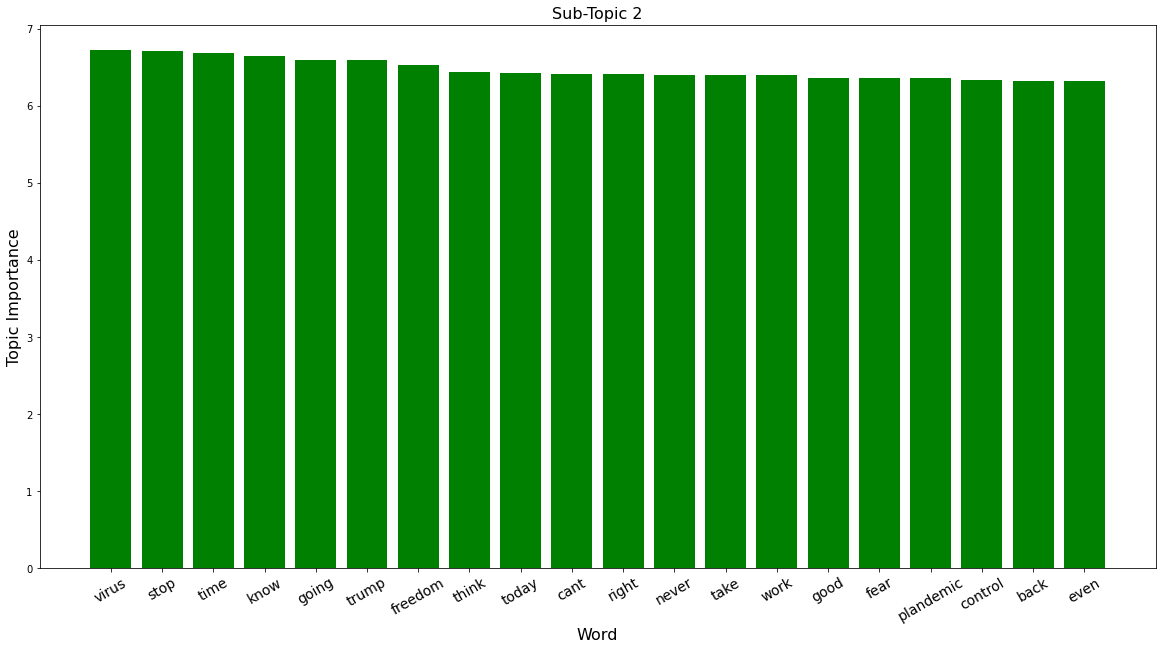

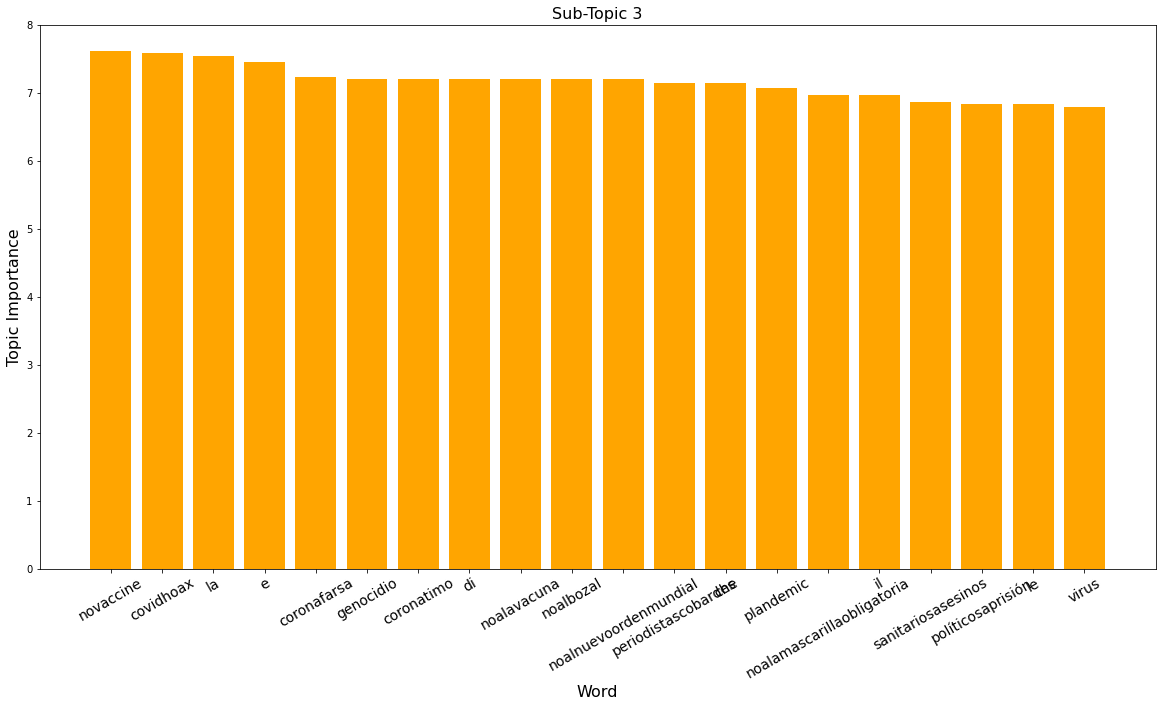

In [19]:
graph_cluster_words(primary_neg, 'clean_text', c_stopwords, 'neg')
for i in range(3):
    samp = primary_neg[primary_neg['cluster_label'] == i].sample(10)
    samp = samp[['username', 'raw_text']]
    samp.to_csv(str(i)+'neg.csv')

In [20]:
graph_cluster_words(primary_pos, 'clean_text', c_stopwords, 'pos')
for i in range(3):
    samp = primary_pos[primary_pos['cluster_label'] == i].sample(10)
    samp = samp[['username', 'raw_text']]
    samp.to_csv(str(i)+'pos.csv')